# Hyperparameter Optimization with Ray Tune
##### Reference
##### [1] https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
##### [2] https://docs.ray.io/en/master/tune/index.html

## 0. Import / Setup

In [1]:
# Import Packages
from functools import partial
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Ray Tune (import more packages later)
from ray import tune

## 1. Data Check

In [2]:
df = pd.read_csv('./data/pima-indians-diabetes.csv', 
                names = ["pregnant", "plasma", "pressure", "thickness", "insulin", "BMI", "pedigree", "age", "class"])
df.head()

,pregnant,plasma,pressure,thickness,insulin,BMI,pedigree,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Pandas to Tensor
dataset = df.values
X_dataset = torch.FloatTensor(dataset[:, 0:8])
Y_dataset = torch.FloatTensor(dataset[:, 8])
tensor_dataset = torch.utils.data.TensorDataset(X_dataset, Y_dataset)

# Train/Test Split
train_test_split = 0.2
train_num = int(len(tensor_dataset)*(1-train_test_split))
trainset, testset = torch.utils.data.random_split(tensor_dataset, 
                    [train_num, len(tensor_dataset)-train_num])

## 2. Network Definition

In [4]:
class SimpleNet(nn.Module):
    def __init__(self, hidden_dim=[16, 8]):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(8, hidden_dim[0])
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.fc3 = nn.Linear(hidden_dim[1], 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1)

## 3. Training Example

In [17]:
# Network Definition
net = SimpleNet(hidden_dim=[16, 8])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
net.to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)

In [18]:
# DataLoader Definition
train_val_split = 0.2
train_num = int(len(trainset)*(1-train_test_split))
train_subset, val_subset = torch.utils.data.random_split(trainset, 
                           [train_num, len(trainset)-train_num])
trainloader = torch.utils.data.DataLoader(
              train_subset,
              batch_size=32,
              shuffle=True,
              num_workers=2
)
valloader   = torch.utils.data.DataLoader(
              val_subset,
              batch_size=32,
              shuffle=True,
              num_workers=2
)

In [19]:
# Train / Validation

start_time = time.time()

train_loss_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(50):

    # Training
    net.train()
    running_loss = 0.0
    epoch_steps = 0

    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1

    # Validation
    net.eval()
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0

    for data in valloader:
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            total += labels.size(0)
            correct += (torch.round(outputs) == labels).sum().item()

            loss = criterion(outputs, labels)
            val_loss += loss.cpu().numpy()
            val_steps += 1

    train_loss_list.append(running_loss / epoch_steps)
    val_loss_list.append(val_loss / val_steps)
    val_acc_list.append(correct / total)
    print("[Epoch: {:02d}] loss: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}".format(epoch + 1, train_loss_list[-1], val_loss_list[-1], val_acc_list[-1]))

print("Finished Training, Time : {:.3f}".format(time.time()-start_time))

[Epoch: 01] loss: 0.779, val_loss: 0.756, val_acc: 0.455
[Epoch: 02] loss: 0.759, val_loss: 0.751, val_acc: 0.455
[Epoch: 03] loss: 0.752, val_loss: 0.749, val_acc: 0.463
[Epoch: 04] loss: 0.741, val_loss: 0.746, val_acc: 0.480
[Epoch: 05] loss: 0.746, val_loss: 0.740, val_acc: 0.463
[Epoch: 06] loss: 0.739, val_loss: 0.737, val_acc: 0.472
[Epoch: 07] loss: 0.728, val_loss: 0.739, val_acc: 0.463
[Epoch: 08] loss: 0.725, val_loss: 0.734, val_acc: 0.439
[Epoch: 09] loss: 0.720, val_loss: 0.731, val_acc: 0.455
[Epoch: 10] loss: 0.712, val_loss: 0.728, val_acc: 0.496
[Epoch: 11] loss: 0.704, val_loss: 0.719, val_acc: 0.512
[Epoch: 12] loss: 0.697, val_loss: 0.718, val_acc: 0.528
[Epoch: 13] loss: 0.699, val_loss: 0.707, val_acc: 0.520
[Epoch: 14] loss: 0.690, val_loss: 0.704, val_acc: 0.569
[Epoch: 15] loss: 0.690, val_loss: 0.706, val_acc: 0.577
[Epoch: 16] loss: 0.688, val_loss: 0.701, val_acc: 0.585
[Epoch: 17] loss: 0.683, val_loss: 0.699, val_acc: 0.634
[Epoch: 18] loss: 0.684, val_lo

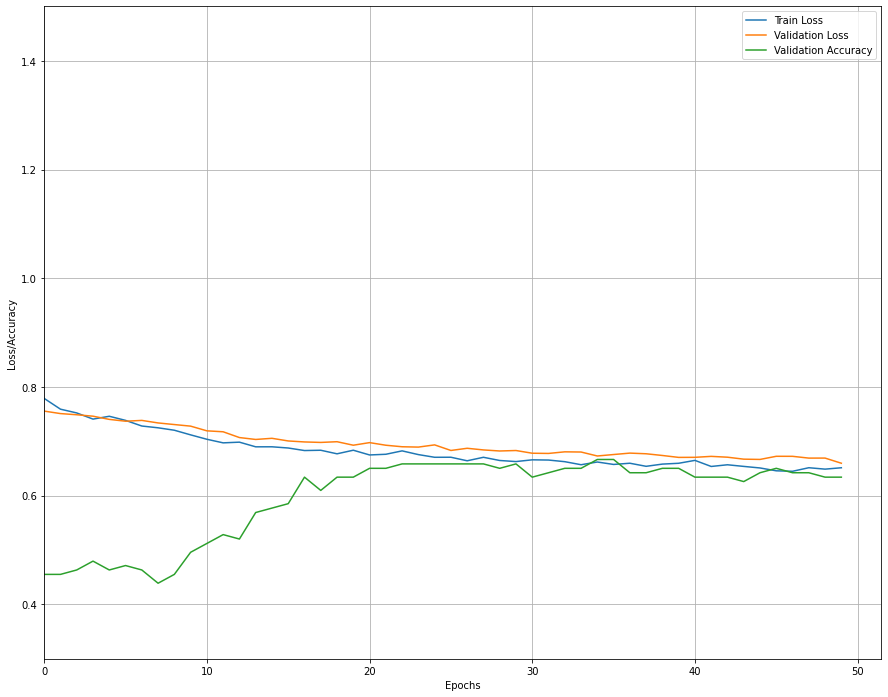

In [20]:
# Learning Curve
plt.figure(figsize=(15,12))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.grid(True)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.xlim(0)
plt.ylim(0.3, 1.5)
plt.show()

## 4. Trainable Function Definition

In [10]:
def train_func(config, checkpoint_dir=None, trainset=trainset):

    # Network Definition
    net = SimpleNet(hidden_dim=[config['L1'], config['L2']])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)


    # DataLoader Definition
    train_val_split = 0.2
    train_num = int(len(trainset)*(1-train_test_split))
    train_subset, val_subset = torch.utils.data.random_split(trainset, 
                               [train_num, len(trainset)-train_num])
    trainloader = torch.utils.data.DataLoader(
                train_subset,
                batch_size=int(config["batch_size"]),
                shuffle=True,
                num_workers=2
    )
    valloader   = torch.utils.data.DataLoader(
                val_subset,
                batch_size=int(config["batch_size"]),
                shuffle=True,
                num_workers=2
    )

    #Train/Validation
    for epoch in range(20):

        # Training
        net.train()
        running_loss = 0.0
        epoch_steps = 0

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1

        # Validation
        net.eval()
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0

        for data in valloader:
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                total += labels.size(0)
                correct += (torch.round(outputs) == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(train_loss=(running_loss / epoch_steps),
                    val_loss=(val_loss / val_steps),
                    val_acc=(correct / total))

    print("Finished Training")

In [11]:
def test_accuracy(net, device="cpu", testset=testset):

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=16, shuffle=False, num_workers=2)

    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            total += labels.size(0)
            correct += (torch.round(outputs) == labels).sum().item()

    return correct / total

## 5. Simple Search Example

In [28]:
# Config Definition
config = {
    'L1': tune.grid_search([4, 8, 16]),
    'L2': tune.grid_search([4, 8, 16]),
    'lr': tune.grid_search([1e-2, 1e-3, 1e-4]),
    'batch_size': 32
}

In [13]:
# Reporter Definition
from ray.tune import JupyterNotebookReporter
reporter = JupyterNotebookReporter(overwrite=True, metric_columns=["train_loss", "val_loss", "val_acc", "training_iteration"])

In [29]:
# Hyperparameter Tuning
result = tune.run(
    partial(train_func, trainset=trainset),
    config=config,
    num_samples=10,
    progress_reporter=reporter,
    metric='val_loss',
    mode='min',
    name='grid_search',
    local_dir='./ray_results')

Trial name,status,loc,L1,L2,lr,train_loss,val_loss,val_acc,training_iteration
DEFAULT_5b7fe_00000,TERMINATED,,4,4,0.01,0.645203,0.662074,0.642276,20
DEFAULT_5b7fe_00001,TERMINATED,,8,4,0.01,0.624465,0.634661,0.707317,20
DEFAULT_5b7fe_00002,TERMINATED,,16,4,0.01,0.62482,0.633068,0.609756,20
DEFAULT_5b7fe_00003,TERMINATED,,4,8,0.01,0.620464,0.721607,0.552846,20
DEFAULT_5b7fe_00004,TERMINATED,,8,8,0.01,0.638649,0.615051,0.699187,20
DEFAULT_5b7fe_00005,TERMINATED,,16,8,0.01,0.608055,0.618784,0.691057,20
DEFAULT_5b7fe_00006,TERMINATED,,4,16,0.01,0.635774,0.642843,0.658537,20
DEFAULT_5b7fe_00007,TERMINATED,,8,16,0.01,0.6099,0.674803,0.569106,20
DEFAULT_5b7fe_00008,TERMINATED,,16,16,0.01,0.590819,0.669974,0.650407,20
DEFAULT_5b7fe_00009,TERMINATED,,4,4,0.001,0.661788,0.669973,0.617886,20


2021-07-05 07:00:13,684	INFO tune.py:549 -- Total run time: 16686.66 seconds (16686.04 seconds for the tuning loop).


In [31]:
# Get Best Trial
best_trial = result.get_best_trial("val_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {:.3f}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final validation accuracy: {:.3f}".format(
    best_trial.last_result["val_acc"]))

# Load Best Trained Model 
best_trained_model = SimpleNet(hidden_dim=[best_trial.config["L1"], best_trial.config["L2"]])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

# Test Accuracy
test_acc = test_accuracy(best_trained_model, device, testset=testset)
print("Best trial test set accuracy: {:.3f}".format(test_acc))

Best trial config: {'L1': 8, 'L2': 4, 'lr': 0.01, 'batch_size': 32}
Best trial final validation loss: 0.567
Best trial final validation accuracy: 0.764
Best trial test set accuracy: 0.708


In [43]:
# Best Dataframe
best_dataframe = result.best_dataframe
best_dataframe.drop(['experiment_id','date','pid','hostname','node_ip'], axis=1)

,train_loss,val_loss,val_acc,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,timestamp,time_total_s,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id
0,1.249822,0.629597,0.747967,24.352832,True,False,NaN,NaN,1,1625430732,24.352832,24.352832,0,1,5b7fe_00190
1,0.682261,0.609898,0.764228,25.974492,True,False,NaN,NaN,2,1625430758,50.327324,50.327324,0,2,5b7fe_00190
2,0.676239,0.636870,0.747967,26.452214,True,False,NaN,NaN,3,1625430785,76.779538,76.779538,0,3,5b7fe_00190
3,0.667860,0.600021,0.756098,24.708879,True,False,NaN,NaN,4,1625430809,101.488417,101.488417,0,4,5b7fe_00190
4,0.661965,0.588224,0.764228,21.552327,True,False,NaN,NaN,5,1625430831,123.040744,123.040744,0,5,5b7fe_00190
5,0.660731,0.569813,0.764228,23.552971,True,False,NaN,NaN,6,1625430855,146.593715,146.593715,0,6,5b7fe_00190
6,0.658840,0.592611,0.747967,24.291994,True,False,NaN,NaN,7,1625430879,170.885709,170.885709,0,7,5b7fe_00190
7,0.656122,0.580863,0.756098,22.494804,True,False,NaN,NaN,8,1625430901,193.380513,193.380513,0,8,5b7fe_00190
8,0.660686,0.603434,0.747967,23.797319,True,False,NaN,NaN,9,1625430925,217.177832,217.177832,0,9,5b7fe_00190
9,0.662025,0.624111,0.699187,22.928642,True,False,NaN,NaN,10,1625430948,240.106475,240.106475,0,10,5b7fe_00190
